In [1]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np
#import keras
#from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
os.listdir('../input')

['hmnist_28_28_RGB.csv',
 'ham10000_images_part_1',
 'HAM10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_images_part_1',
 'HAM10000_metadata.csv',
 'hmnist_8_8_RGB.csv',
 'hmnist_8_8_L.csv',
 'ham10000_images_part_2']

In [3]:


# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 7 folders inside 'base_dir':

# train_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df
    
# val_dir
    # nv
    # mel
    # bkl
    # bcc
    # akiec
    # vasc
    # df

# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN, VALIDATION AND TEST FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)



# create new folders inside val_dir
nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



In [4]:
df_data = pd.read_csv('../input/HAM10000_metadata.csv')

df_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [5]:
# this will tell us how many images are associated with each lesion_id
df = df_data.groupby('lesion_id').count()


In [6]:
# now we filter out lesion_id's that have only one image associated with it
df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000001,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1


In [7]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
# create a new colum that is a copy of the lesion_id column
df_data['duplicates'] = df_data['lesion_id']
# apply the function to this new column
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)


In [8]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [9]:
# now we filter out images that don't have duplicates
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [10]:
# now we create a val set using df because we are sure that none of these images
# have augmented duplicates in the train set
y = df['dx']

_, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=y)

df_val.shape

(1103, 8)

In [11]:
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [12]:
# This set will be df_data excluding all rows that are in the val set

# This function identifies if an image is part of the train
# or val set.
def identify_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# identify train and val rows

# create a new colum that is a copy of the image_id column
df_data['train_or_val'] = df_data['image_id']
# apply the function to this new column
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
# filter out train rows
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

8912
1103


In [13]:
#Train
df_train['dx'].value_counts()


nv       5822
mel      1067
bkl      1011
bcc       479
akiec     297
vasc      129
df        107
Name: dx, dtype: int64

In [14]:
#Validation
df_val['dx'].value_counts()

nv       883
bkl       88
mel       46
bcc       35
akiec     30
vasc      13
df         8
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [15]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [16]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/ham10000_images_part_1')
folder_2 = os.listdir('../input/ham10000_images_part_2')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_1', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/ham10000_images_part_2', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)
        

In [17]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
1067
1011
479
297
129
107


In [18]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

883
46
88
35
30
13
8


### Copy the train images  into aug_dir

In [19]:
# note that we are not augmenting class 'nv'
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    # We are creating temporary directories here because we delete these directories later
    # create a base dir
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # create a dir within the base dir to store images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    # Choose a class
    img_class = item

    # list all images in that directory
    img_list = os.listdir('base_dir/train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir e.g. class 'mel'
    for fname in img_list:
            # source path to image
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            # destination path to image
            dst = os.path.join(img_dir, fname)
            # copy the image from the source to the destination
            shutil.copyfile(src, dst)


    # point to a dir containing the images and not to the images themselves
    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    # Create a data generator
    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    # Generate the augmented images and add them to the training folders
    
    ###########
    
    num_aug_images_wanted = 8000 # total number of images we want to have in each class
    
    ###########
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    # run the generator and create about 6000 augmented images
    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    # delete temporary directory with the raw image files
    shutil.rmtree('aug_dir')

Found 1067 images belonging to 1 classes.
Found 1011 images belonging to 1 classes.
Found 479 images belonging to 1 classes.
Found 297 images belonging to 1 classes.
Found 129 images belonging to 1 classes.
Found 107 images belonging to 1 classes.


In [20]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5822
7819
7777
7714
7972
6937
5771


In [21]:
# Check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

883
46
88
35
30
13
8


### Visualize 50 augmented images

/opt/conda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


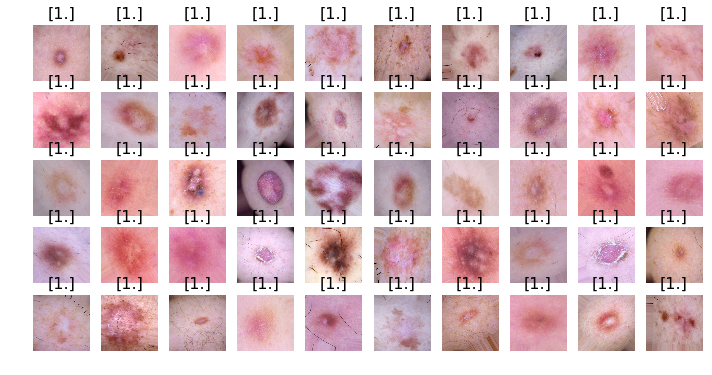

In [22]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=labels) # titles=labels will display the image labels

In [23]:
# End of Data Preparation
### ===================================================================================== ###
# Start of Model Building

### Set Up the Generators

In [24]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [25]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 49812 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.
Found 1103 images belonging to 7 classes.


### MobileNet Model

In [26]:
# create a copy of a mobilenet model

mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 1s 0us/step


In [27]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [28]:
type(mobile.layers)

list

In [29]:
# How many layers does MobileNet have?
len(mobile.layers)

93

In [30]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

# Create a new dense layer for predictions
# 7 corresponds to the number of classes
x = Dropout(0.3)(x)
predictions = Dense(7, activation='sigmoid')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128   

In [32]:
# We need to choose how many layers we actually want to be trained.

# Here we are freezing the weights of all layers except the
# last 20 layers in the new model.
# The last 20 layers of the model will be trained.

for layer in model.layers[:-20]:
    layer.trainable = False

### Train the Model

In [33]:
# Define Top2 and Top3 Accuracy

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [34]:
model.compile(
    Adam(lr=0.00005), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])


In [35]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [36]:
# Add weights to try to make the model more sensitive to melanoma

class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [37]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.000001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=60, verbose=1,
                   callbacks=callbacks_list)


Train for 892.0 steps, validate for 111.0 steps
Epoch 1/60
890/892 [============================>.] - ETA: 0s - loss: 1.6768 - categorical_accuracy: 0.4479 - top_2_accuracy: 0.6847 - top_3_accuracy: 0.8172
Epoch 00001: val_top_3_accuracy improved from -inf to 0.91750, saving model to model.h5
892/892 [==============================] - 57s 63ms/step - loss: 1.6770 - categorical_accuracy: 0.4478 - top_2_accuracy: 0.6850 - top_3_accuracy: 0.8172 - val_loss: 1.1245 - val_categorical_accuracy: 0.5893 - val_top_2_accuracy: 0.8486 - val_top_3_accuracy: 0.9175
Epoch 2/60
891/892 [============================>.] - ETA: 0s - loss: 1.2151 - categorical_accuracy: 0.5960 - top_2_accuracy: 0.8213 - top_3_accuracy: 0.9240
Epoch 00002: val_top_3_accuracy improved from 0.91750 to 0.92928, saving model to model.h5
892/892 [==============================] - 50s 57ms/step - loss: 1.2151 - categorical_accuracy: 0.5959 - top_2_accuracy: 0.8214 - top_3_accuracy: 0.9241 - val_loss: 0.9080 - val_categorical_ac

### Evaluate the model using the val set

In [38]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [39]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.814422294230463
val_cat_acc: 0.724388
val_top_2_acc: 0.8875793
val_top_3_acc: 0.9410698


In [40]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.8191038184614129
val_cat_acc: 0.7162285
val_top_2_acc: 0.88667274
val_top_3_acc: 0.9419764


### Plot the Training Curves

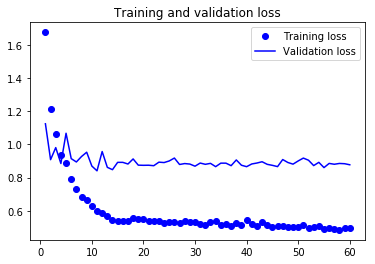

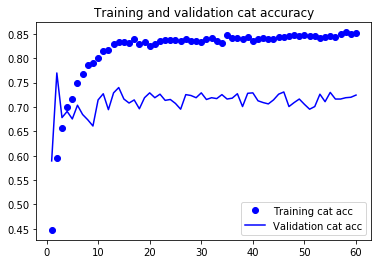

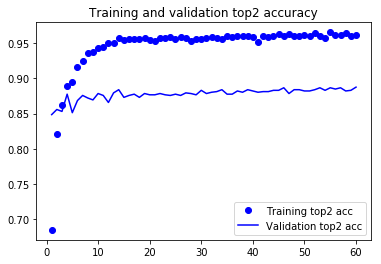

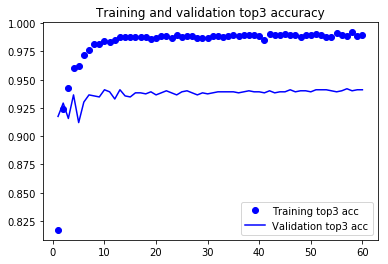

In [41]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [42]:
# Get the labels of the test images.

test_labels = test_batches.classes

In [43]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [44]:
# Print the label associated with each class
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [45]:
# make a prediction
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

1103/1103 [==============================] - 16s 15ms/step


In [46]:
predictions.shape

(1103, 7)

In [47]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [48]:
test_labels.shape

(1103,)

In [49]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [50]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[  2   1   1   1  21   4   0]
 [  0  12   0   1  10  10   2]
 [  4   8   4   3  50  17   2]
 [  0   0   0   4   1   3   0]
 [  0   3   1   1  32   9   0]
 [  2   2   0   7 137 731   4]
 [  0   0   0   0   1   7   5]]


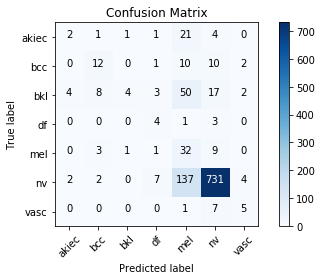

In [51]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [52]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

In [53]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

       akiec       0.25      0.07      0.11        30
         bcc       0.46      0.34      0.39        35
         bkl       0.67      0.05      0.09        88
          df       0.24      0.50      0.32         8
         mel       0.13      0.70      0.21        46
          nv       0.94      0.83      0.88       883
        vasc       0.38      0.38      0.38        13

    accuracy                           0.72      1103
   macro avg       0.44      0.41      0.34      1103
weighted avg       0.84      0.72      0.74      1103



**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.